In [ ]:
# default_exp core

# Checkpoints

> Reducing memory usage on resnets.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastai2.vision.all import *

In [ ]:
PATH = Path('results')

## Memory Utils
> from [here](https://www.sicara.ai/blog/2019-28-10-deep-learning-memory-usage-and-pytorch-optimization-tricks)

In [ ]:
#export
def _get_gpu_mem(synchronize=True, empty_cache=True):
    "gpu memory utilization"
    return torch.cuda.memory_allocated(), torch.cuda.memory_cached()

Basic memory hook func

In [ ]:
def mem_func(m, i, o):
    mem_all, mem_cached = _get_gpu_mem()
    torch.cuda.synchronize()
#     print(f'{type(m).__name__: <15}: {o.shape}')
    return type(m).__name__, mem_all//2 **20, mem_cached//2 **20

In [ ]:
m = ResBlock(1, 3, 64).cuda()

In [ ]:
x = torch.rand(8, 3, 512, 512).cuda()

In [ ]:
m.summary(x)

ResBlock (Input shape: ['8 x 3 x 512 x 512'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 512 x 512   1,728      True      
________________________________________________________________
BatchNorm2d          8 x 64 x 512 x 512   128        True      
________________________________________________________________
ReLU                 8 x 64 x 512 x 512   0          False     
________________________________________________________________
Conv2d               8 x 64 x 512 x 512   36,864     True      
________________________________________________________________
BatchNorm2d          8 x 64 x 512 x 512   128        True      
________________________________________________________________
Conv2d               8 x 64 x 512 x 512   192        True      
________________________________________________________________
BatchNorm2d          8 x 64 x 512 x 512   128        True      
____________________________________________________

In [ ]:
def get_leafs(m: nn.Module):
    "return leafs of pytorch module"
    if not list(m.children()):
        return m
    else:
        return L(get_leafs(c) for c in list(m.children())).concat()

In [ ]:
get_leafs(m)

(#8) [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),ReLU(),Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),ReLU(inplace=True)]

In [ ]:
get_leafs(nn.Conv1d(3,3,3))

Conv1d(3, 3, kernel_size=(3,), stride=(1,))

In [ ]:
with Hooks(get_leafs(m), mem_func) as hooks:
    m(x)

In [ ]:
hooks.stored

(#8) [('Conv2d', 694, 1836),('BatchNorm2d', 1206, 2348),('ReLU', 1718, 2860),('Conv2d', 2230, 3372),('BatchNorm2d', 2742, 3884),('Conv2d', 3254, 4396),('BatchNorm2d', 3766, 4908),('ReLU', 3254, 5420)]

In [ ]:
def get_pass_mem(hooks):
    df = (pd.DataFrame(hooks.stored, columns=['name', 'mem_all', 'mem_cached'])
            .assign(mem_all = lambda df : df.mem_all,
                    mem_cached = lambda df : df.mem_cached)
            .loc[:,'mem_all'])
    return df

In [ ]:
def plot_mem(hooks, ax=None, return_df=False, **kwargs):
    if ax is None: fig, ax = plt.subplots(figsize=(8,4), **kwargs)
    df = get_pass_mem(hooks)
    df.plot(ax=ax)
    ax.set_xlabel('layers')
    ax.set_ylabel('MB')
    return ax

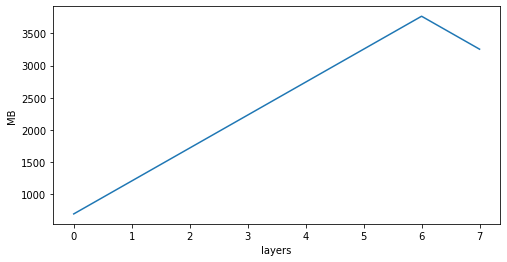

In [ ]:
ax = plot_mem(hooks)

In [ ]:
model = create_cnn_model(resnet18, 1).cuda()

In [ ]:
model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
fhooks = Hooks(get_leafs(model[0]), mem_func)
bhooks = Hooks(get_leafs(model[0])[::-1], mem_func, is_forward=False)

In [ ]:
out = model(x)
loss = out.sum()
loss.backward()

In [ ]:
fhooks.remove()
bhooks.remove()

In [ ]:
@delegates(plt.subplots)
def profile_memory(model, x, ax=None, color='b', **kwargs):
    fhooks = Hooks(get_leafs(model), mem_func)
    bhooks = Hooks(get_leafs(model)[::-1], mem_func, is_forward=False)
    out = model(x)
    loss = out.sum()
    loss.backward()
    if ax is None: 
        _, ax = plt.subplots(figsize=(8,4), **kwargs)
    fdf = get_pass_mem(fhooks)
    bdf = get_pass_mem(bhooks)
    df = pd.concat([fdf, bdf]).reset_index(drop=True)
    df -= df.min()
    df.plot(ax=ax, color=color)
    ax.axvspan(len(fdf), len(fdf)+len(bdf), alpha=0.2)
    ax.set_xlabel('layers')
    ax.set_ylabel('MB');
    return ax

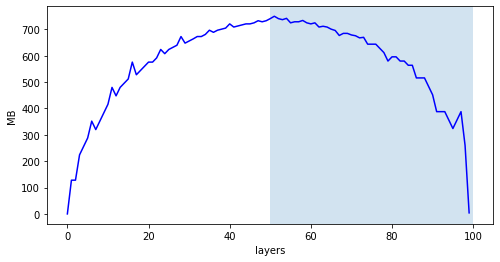

In [ ]:
ax = profile_memory(model[0],x)

## Checkpoints

In [ ]:
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

In [ ]:
class CheckpointModule(Module):
    def __init__(self, module, num_segments=1):
        assert num_segments == 1 or isinstance(module, nn.Sequential)
        self.module = module
        self.num_segments = num_segments

    def forward(self, *inputs):
        if self.num_segments > 1:
            return checkpoint_sequential(self.module, self.num_segments, *inputs)
        else:
            return checkpoint(self.module, *inputs)

In [ ]:
# To extract the sequential layers from resnet
def layer_config(arch):
    "Get the layers associated with `arch`."
    return model_layers.get(arch)

In [ ]:
model_layers = {
    resnet18 :[2, 2, 2, 2], resnet34: [3, 4, 6, 3],
    resnet50 :[3, 4, 6, 3], resnet101:[3, 4, 23, 3],
    resnet152:[3, 8, 36, 3]}

In [ ]:
body = create_body(resnet18)

In [ ]:
layer_config(resnet18)

[2, 2, 2, 2]

In [ ]:
from fastai2.vision.learner import _update_first_layer

In [ ]:
## Send sequential layers in custom_body to Checkpoint
def create_body_cp(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `model` at `cut` (int) or cut the model as specified by `cut(model)` (function)."
    model = arch(pretrained=pretrained)
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int):
      #Checkpoint - Changes Start
        if (arch.__name__).find("resnet")==0: 
            layers = layer_config(arch)
            n=4 #to remove stem
            out = nn.Sequential(CheckpointModule(nn.Sequential(*list(model.children())[:cut][:n])),
                                *[CheckpointModule(x, layers[i]) for i, x in enumerate(list(model.children())[n:cut])])
        else:
            out = nn.Sequential(*list(model.children())[:cut])
        return out
    #Checkpoint - Changes End
    elif isinstance(cut, Callable): return cut(model)
    else:                           raise NamedError("cut must be either integer or a function")

In [ ]:
model_cp = create_body_cp(resnet18).cuda()

In [ ]:
model_cp

Sequential(
  (0): CheckpointModule(
    (module): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
  )
  (1): CheckpointModule(
    (module): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Ba

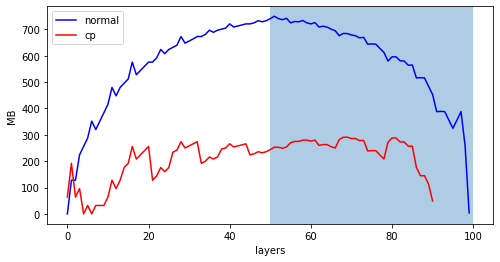

In [ ]:
ax = profile_memory(model[0], x)
profile_memory(model_cp, x, ax=ax, color='r')
ax.legend(['normal', 'cp'])